# Construct stacked image from k2sne data
Query the server to get a list of images, retrieve those images, create a stack

In [1]:
%matplotlib inline
from __future__ import print_function
import os, numpy, warnings
from astropy.io import fits
from astropy.table import Table
import pylab

In [2]:
def getimages(ra,dec,size=240,filters="griz",auxiliary="data,mask"):
    
    """Query hlspfilenames.py service to get a list of images
    
    ra, dec = position in degrees
    size = image size in pixels (0.25 arcsec/pixel)
    Returns a table with the results
    """
    
    service = "https://ps1images.stsci.edu/cgi-bin/hlspfilenames.py"
    url = ("{service}?ra={ra}&dec={dec}&size={size}&format=fits"
           "&auxiliary={auxiliary}&filters={filters}").format(**locals())
    table = Table.read(url, format='ascii')
    return table

def groupimages(table):
    
    """Group images by filter and image type
    
    Returns a nested dictionary:
    d[filter] = {'warp': rowlist, 'warp.mask': rowlist}
    where the row lists are sorted by mjd
    """
    
    d = {}
    for row in table:
        filter = row['filter']
        dsub = d.setdefault(filter,{})
        dsub.setdefault(row['type'],[]).append((row['mjd'], row))
    # sort row lists by MJD and strip off the mjd value
    for filter, entry in d.items():
        for filetype, flist in entry.items():
            flist.sort()
            entry[filetype] = [x[1] for x in flist]            
    return d

ra0 = 208.206013
dec0 = -6.963419
table = getimages(ra0,dec0,size=1024)
print('Found', len(table), 'images')
print('Columns:', table.colnames)
groups = groupimages(table)
print(len(groups),'filters')
for filter, entry in groups.items():
    for filetype, flist in entry.items():
        print(filter,filetype,len(flist))

Found 56 images
Columns: ['projcell', 'subcell', 'ra', 'dec', 'filter', 'mjd', 'type', 'filename', 'url']
3 filters
i warp.mask 5
i warp 5
r warp.mask 7
r warp 7
g warp.mask 16
g warp 16


In [3]:
def stackimages(imagelist, masklist):
    """Read FITS images from URLs and stack them
    
    imagelist is list of rows (from getimages) for the data
    masklist is corresponding list of rows for the stacks
    Returns stacked image, count of exposures in stack
    """
    n = len(imagelist)
    if n != len(masklist):
        raise ValueError("Mis-match in imagelist and masklist")
    if n == 0:
        raise ValueError("imagelist is empty")
    # assume all images are the same size
    im0 = fits.open(imagelist[0])[0].data
    mask0 = fits.open(masklist[0])[0].data
    # mask ought to be int but is float for some reason
    mask0[numpy.isnan(mask0)] = 0
    mask0 = mask0.astype(numpy.int32)
    imstack = numpy.zeros((n,im0.shape[0],im0.shape[1]), dtype=im0.dtype)
    imstack[0] = im0
    maskstack = numpy.zeros((n,im0.shape[0],im0.shape[1]), dtype=mask0.dtype)
    maskstack[0] = mask0
    for i in range(1,n):
        imstack[i] = fits.open(imagelist[i])[0].data
        mask0 = fits.open(masklist[i])[0].data
        mask0[numpy.isnan(mask0)] = 0
        maskstack[i] = mask0.astype(numpy.int32)
    # ignore all non-zero mask values in stack (conservative)
    imstack[maskstack != 0] = numpy.nan
    # suppress the annoying nanmean warning where all pixels are blank
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        im = numpy.nanmean(imstack,axis=0)
    count = numpy.isfinite(imstack).sum(axis=0)
    return im, count

filter = 'i'
fdict = groups[filter]
imagelist = [x['url'] for x in fdict['warp']]
masklist = [x['url'] for x in fdict['warp.mask']]
im, count = stackimages(imagelist, masklist)

Number of blank pixels 3076
Image min max -41.0106 19018.3


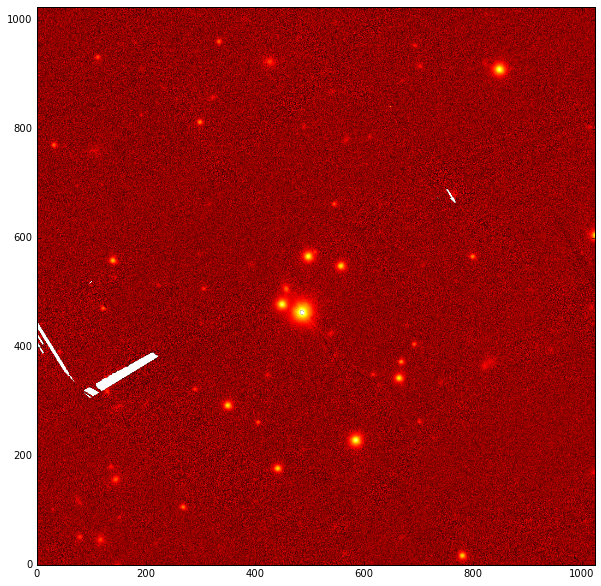

In [4]:
print('Number of blank pixels',(count==0).sum())
print('Image min max',numpy.nanmin(im),numpy.nanmax(im))
pylab.figure(1,(10,10))
pylab.imshow(numpy.arcsinh(im/10), cmap='hot')